In [7]:
from matplotlib import pyplot as plt
plt.rcParams["figure.autolayout"] = True
plt.figure()
manager = plt.get_current_fig_manager()
manager.full_screen_toggle()
plt.show()
plt.rcParams["figure.figsize"] = [10.00, 7.00]

<Figure size 1000x700 with 0 Axes>

Loaded tensor: (2, 149, 5265) (B,T,V)
Concatenated: (T=149, F=10530) with pq=2, V=5265
Windows: X=(146, 3, 10530), y=(146, 10530)
Breakdon: 116
Train: (116, 3, 10530), Test: (30, 3, 10530)
Normalization ON (minmax). Params learned on TRAIN only.
Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 1.1113e-04 - mae: 0.0020 - val_loss: 1.2571e-04 - val_mae: 0.0021
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.0476e-04 - mae: 0.0020 - val_loss: 1.1903e-04 - val_mae: 0.0023
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 9.8782e-05 - mae: 0.0022 - val_loss: 1.1309e-04 - val_mae: 0.0025
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 9.3513e-05 - mae: 0.0024 - val_loss: 1.0747e-04 - val_mae: 0.0025
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 8.8290e-05 - mae: 0.0024 - val_loss: 1.0195e-04 - val_mae: 0.0026
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 8.3554e-05 - mae: 0.0024 - val_loss: 9.6110e-05 - val_mae: 0.0026
Epoch 7/20
4/4 ━

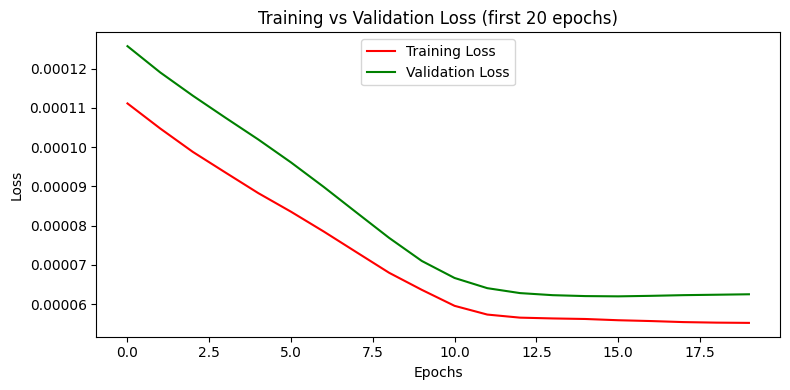

In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Full pipeline with optional normalization:
Load → (optional normalize) → Train → Predict → Denormalize → Evaluate → Save → Visualize

Inputs
------
- big_tensor.npy : shape (B, T, V)  (aligned & zero-filled popularity vectors)

Main Features
-------------
1) Concatenate first `pq` big boxes along features → (T, pq*V)
2) Sliding windows of length `time_sequence` to predict next step
3) Compact model: TimeDistributed(Dense)->LSTM->Dense->Dense
4) Optional normalization (minmax or zscore), fit on TRAIN ONLY
5) Predict on test split; denormalize for metrics/saving
6) Save predictions/ground-truth (denormalized) and metrics
7) Visualize:
   - Training vs Validation loss curves
   - Actual vs Predicted (subset of dims)

Outputs
-------
- allresultpfresh.npy  : (pq, N_eval, V) predictions (denormalized, original scale)
- alltruefresh.npy     : (pq, N_eval, V) ground truth (denormalized, original scale)
- metrics_fresh.csv    : MAE/MSE per box + overall (original scale)
"""

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Input
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
TENSOR_PATH   = "big_Popularity_tensor.npy"

pq            = 2            # number of big boxes concatenated along features
time_sequence = 3            # sliding window length
train_ratio   = 0.8          # chronological split

# Model sizes (reduce if you hit memory limits)
proj_dim      = 512          # per-timestep projection size
rnn_units     = 256          # LSTM units
learning_rate = 1e-3
batch_size    = 32
max_epochs    = 20
patience      = 10

# Normalization (toggle ON/OFF)
NORMALIZE          = True     # << set False to run without normalization
NORMALIZATION_TYPE = "minmax" # "minmax" or "zscore"

# Saving
SAVE_PRED     = "predictedPopularity.npy"
SAVE_TRUE     = "truthPopularity.npy"
SAVE_METRICS  = "metrics_freshPopularity.csv"

# Visualization selection
VIS_SAMPLE_IDX = -1          # which test sample to visualize (-1 = last)
VIS_BOX_J      = 0           # which big box slice (0..pq-1)
VIS_K_MAX      = 2000        # first K dims to plot
# ----------------------------------------


def build_feature_matrix(pvect: np.ndarray, pq: int) -> np.ndarray:
    """Concatenate the first pq big boxes along features: (B,T,V) -> (T, pq*V)."""
    assert pq <= pvect.shape[0], "pq exceeds number of big boxes in tensor"
    parts = [pvect[i] for i in range(pq)]              # each (T, V)
    RCF = np.concatenate(parts, axis=1).astype(np.float32)
    return RCF


def make_windows(RCF: np.ndarray, time_sequence: int):
    """Build sliding windows: X: (N, ts, F), y: (N, F)."""
    T, F = RCF.shape
    X = np.array([RCF[i:i+time_sequence] for i in range(T - time_sequence)], dtype=np.float32)
    y = np.array([RCF[i+time_sequence]    for i in range(T - time_sequence)], dtype=np.float32)
    return X, y


def split_train_test(X, y, ratio: float):
    N = X.shape[0]
    split = int(ratio * N)
    print('Breakdon:',split)
    return X[:split], y[:split], X[split:], y[split:]


def build_model(time_sequence: int, F: int, proj_dim: int, rnn_units: int, lr: float):
    model = Sequential([
        Input(shape=(time_sequence, F)),
        TimeDistributed(Dense(proj_dim, activation="relu")),  # per-step compression
        LSTM(rnn_units),
        Dense(proj_dim, activation="relu"),
        Dense(F)                                             # back to full size
    ])
    model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=["mae"])
    return model


def split_per_box(matrix_2d: np.ndarray, V: int):
    """(N, F=pq*V) -> (pq, N, V)"""
    N, F = matrix_2d.shape
    assert F % V == 0, "F must be multiple of V"
    _pq = F // V
    blocks = np.stack([matrix_2d[:, j*V:(j+1)*V] for j in range(_pq)], axis=0)
    return blocks


# ---------- Normalization helpers (fit on TRAIN ONLY) ----------
def fit_normalizer(train_data_2d: np.ndarray, method: str):
    """
    Fit normalization params on flattened train data.
    train_data_2d: shape (N_train, F)
    Returns params tuple depending on method.
    """
    if method == "minmax":
        mn = np.min(train_data_2d)
        mx = np.max(train_data_2d)
        return (mn, mx)
    elif method == "zscore":
        mean = np.mean(train_data_2d)
        std  = np.std(train_data_2d) + 1e-8
        return (mean, std)
    else:
        raise ValueError("Unknown normalization method")


def apply_normalizer(data_2d: np.ndarray, params, method: str):
    """Apply normalization to 2D data (N, F)."""
    if method == "minmax":
        mn, mx = params
        return (data_2d - mn) / (mx - mn + 1e-8)
    elif method == "zscore":
        mean, std = params
        return (data_2d - mean) / std
    else:
        raise ValueError("Unknown normalization method")


def invert_normalizer(data_2d: np.ndarray, params, method: str):
    """Invert normalization to original scale for 2D data (N, F)."""
    if method == "minmax":
        mn, mx = params
        return data_2d * (mx - mn + 1e-8) + mn
    elif method == "zscore":
        mean, std = params
        return data_2d * std + mean
    else:
        raise ValueError("Unknown normalization method")


# ---------------- Visualization ----------------
def visualize_loss(history):
    n = len(history.history.get("loss", []))
    m = min(20, n) if n > 0 else 0
    if m == 0:
        print("No loss history to plot.")
        return
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'][:m], c='r', label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'][:m], c='g', label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='upper center')
    plt.title(f"Training vs Validation Loss (first {m} epochs)")
    plt.tight_layout()
    plt.show()


def visualize_vectors(true_per_box, pred_per_box, box_j, sample_idx, k_max):
    V = true_per_box.shape[2]
    if true_per_box.shape[1] == 0:
        print("No samples to visualize.")
        return
    # normalize negative sample index
    si = sample_idx if sample_idx >= 0 else (true_per_box.shape[1] + sample_idx)
    si = max(0, min(si, true_per_box.shape[1] - 1))
    K = min(k_max, V)

    y_true_vec = true_per_box[box_j, si]
    y_pred_vec = pred_per_box[box_j, si]

    plt.figure(figsize=(12, 4))
    plt.plot(y_true_vec[:K], label="true", linewidth=1)
    plt.plot(y_pred_vec[:K], label="pred", linewidth=1)
    plt.title(f"Actual vs Predicted (Box {box_j}, sample {si})")
    plt.xlabel(f"small_id (first {K})")
    plt.ylabel("popularity count")
    plt.legend()
    plt.tight_layout()
    plt.show()

# 1) Load tensor
pvect = np.load(TENSOR_PATH)  # (B, T, V)
B, T_total, V = pvect.shape
print(f"Loaded tensor: {pvect.shape} (B,T,V)")

# 2) Features
RCF = build_feature_matrix(pvect, pq)    # (T, pq*V)
T, F = RCF.shape
print(f"Concatenated: (T={T}, F={F}) with pq={pq}, V={V}")

# 3) Windows
X, y = make_windows(RCF, time_sequence)  # X: (N, ts, F), y: (N, F)
N = X.shape[0]
print(f"Windows: X={X.shape}, y={y.shape}")

# 4) Split
x_train, y_train, x_test, y_test = split_train_test(X, y, train_ratio)
print(f"Train: {x_train.shape}, Test: {x_test.shape}")

# 5) Optional normalization (fit on TRAIN ONLY)
if NORMALIZE:
    # Fit on train y (targets) and train X (inputs) using flattened 2D views
    y_train_2d = y_train.reshape(y_train.shape[0], -1)  # (N_train, F)
    params_y = fit_normalizer(y_train_2d, NORMALIZATION_TYPE)

    # Normalize y
    y_train = apply_normalizer(y_train_2d, params_y, NORMALIZATION_TYPE).reshape(y_train.shape)
    y_test  = apply_normalizer(y_test.reshape(y_test.shape[0], -1), params_y, NORMALIZATION_TYPE).reshape(y_test.shape)

    # Normalize X per feature as well using SAME params_y (simple, consistent)
    # (You could fit separate params for X; here we use y's params to keep scale aligned.)
    x_train = apply_normalizer(x_train.reshape(x_train.shape[0], -1), params_y, NORMALIZATION_TYPE).reshape(x_train.shape)
    x_test  = apply_normalizer(x_test.reshape(x_test.shape[0], -1), params_y, NORMALIZATION_TYPE).reshape(x_test.shape)

    print(f"Normalization ON ({NORMALIZATION_TYPE}). Params learned on TRAIN only.")
else:
    print("Normalization OFF.")

# 6) Model
model = build_model(time_sequence, F, proj_dim, rnn_units, learning_rate)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience, restore_best_weights=True)
history = model.fit(
    x_train, y_train,
    epochs=max_epochs,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    callbacks=[early],
    verbose=1
)

# 7) Loss curve
visualize_loss(history)


Breakdon: 0
Train: (0, 3, 10530), Test: (146, 3, 10530)
Predicted: (146, 10530)

=== Evaluation (Original Scale) ===
Box 0: MAE=8.673273  MSE=1938.211182
Box 1: MAE=7.260485  MSE=1307.916138
Overall: MAE=7.966879  MSE=1623.063599

Saved predictions: predictedPopularity.npy  shape=(2, 146, 5265)
Saved ground truth: truthPopularity.npy  shape=(2, 146, 5265)
Saved metrics CSV: metrics_freshPopularity.csv


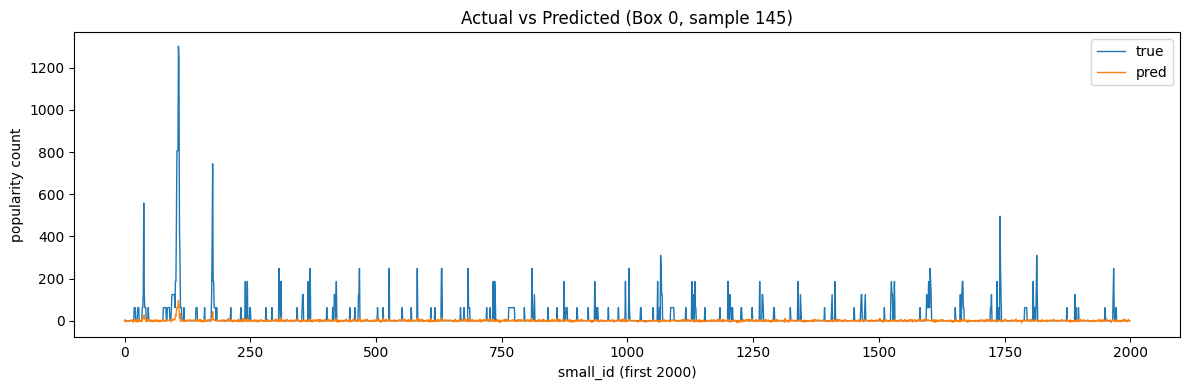

In [10]:
# 4) Split
x_train, y_train, x_test, y_test = split_train_test(X, y, 0.0)
print(f"Train: {x_train.shape}, Test: {x_test.shape}")

# 8) Predict on test
y_pred = model.predict(x_test, verbose=0)  # (N_eval, F)
N_eval = y_pred.shape[0]
print(f"Predicted: {y_pred.shape}")

# 9) Denormalize predictions & ground-truth back to original scale for metrics/saving
if NORMALIZE:
    y_pred = invert_normalizer(y_pred, params_y, NORMALIZATION_TYPE)
    y_test = invert_normalizer(y_test, params_y, NORMALIZATION_TYPE)

# 10) Split per box (pq, N_eval, V)
pred_per_box = split_per_box(y_pred, V)
true_per_box = split_per_box(y_test, V)

# 11) Metrics (original scale)
mae_per_box = np.mean(np.abs(pred_per_box - true_per_box), axis=(1,2))
mse_per_box = np.mean((pred_per_box - true_per_box) ** 2, axis=(1,2))
mae_overall = np.mean(np.abs(y_pred - y_test))
mse_overall = np.mean((y_pred - y_test) ** 2)

print("\n=== Evaluation (Original Scale) ===")
for j in range(pq):
    print(f"Box {j}: MAE={mae_per_box[j]:.6f}  MSE={mse_per_box[j]:.6f}")
print(f"Overall: MAE={mae_overall:.6f}  MSE={mse_overall:.6f}")

# 12) Save outputs
save_dir = os.path.dirname(SAVE_PRED)
if save_dir != "":
    os.makedirs(save_dir, exist_ok=True)
np.save(SAVE_PRED, pred_per_box)  # (pq, N_eval, V)
np.save(SAVE_TRUE, true_per_box)  # (pq, N_eval, V)
with open(SAVE_METRICS, "w") as f:
    f.write("box,mae,mse\n")
    for j in range(pq):
        f.write(f"{j},{mae_per_box[j]},{mse_per_box[j]}\n")
    f.write(f"overall,{mae_overall},{mse_overall}\n")

print(f"\nSaved predictions: {SAVE_PRED}  shape={pred_per_box.shape}")
print(f"Saved ground truth: {SAVE_TRUE}  shape={true_per_box.shape}")
print(f"Saved metrics CSV: {SAVE_METRICS}")

# 13) Visualization: Actual vs Predicted (subset of dims)
if N_eval > 0:
    visualize_vectors(true_per_box, pred_per_box,
                      box_j=VIS_BOX_J, sample_idx=VIS_SAMPLE_IDX, k_max=VIS_K_MAX)
else:
    print("No evaluation samples to visualize.")

In [18]:
'''
This code snippet implements the PPPN Algorithm (Prefetch at the starting of an episode and then no replacement)
'''
import numpy as np
import pandas as pd

result=np.load('predictedPopularity.npy',allow_pickle=True)
P_Test=np.load('map_requests.npy',allow_pickle=True)

def NormalizeData(a,b,data):
    mini=a
    maxi=b
    X_std=(data - np.min(data)) / (np.max(data) - np.min(data))
    X_scaled = X_std * (maxi - mini) + mini
    return X_scaled
ROC=[21,22] #Cellular area ID, for San Francisco its [12,13]
DC=[1,2,3,4,5,6,7,8,9,10] #% of total map segmet number, to be used as cache size
X=[]
for i in DC:
    X.append(str(i))
NMS=5267 #total map segments traveres from ROC at least once.
NN=[]
for i in range(len(DC)+1):
    if i==0:
        NN.append(' ')
    else:
        NN.append(str(DC[i-1])+'%')


Z_Test=[]
for el in P_Test:
    Z_Test.append(el[116:]) #80:20 split of map requests. for San Francisco data its 473
Z_Test=np.array(Z_Test)


#Overall Maximum Penalty and Hits are calculated
COU=[]
PEN=[]
for t in range(2):
    L_Test=Z_Test[t]
    c=0
    p=0
    temp={}
    for l in range(30): ##99 for San Francisco dataset
        cm=0
        for j in range(1,7):
            for ul in L_Test[l][0][j]:
                #print(ul[1])
                c=c+1
                p=p+ul[1]
                cm=cm+1
        temp[l]=cm
    COU.append(c)
    PEN.append(p)
result=NormalizeData(0,1,result) #Normalization of UWP while using Algorithms


# --- Keep ONLY PPPN ---
algo = ['PPPN']
rand = range(Z_Test.shape[1])

HITDC = []      # per-test PPPN hits (list of arrays, one per test t)
PENDC = []      # per-test PPPN penalties (list of arrays, one per test t)

for t in range(2):  # assuming two tests, consistent with your original code
    L_Test = Z_Test[t]
    result1 = result[t][116:]  # predicted scores aligned to evaluation range

    # cache capacities from DC% of NMS
    cache = [int((i / 100) * NMS) for i in DC]

    PPPN_hits = []
    PPPN_penalty = []

    for c in cache:
        HITVSMISS = []
        for l in rand:
            hit = 0
            miss = 0
            sup = 0
            for j in range(1, 7):
                for ul in L_Test[l][0][j]:
                    i = ul[0]
                    up = ul[1]
                    # Top-c by model score for this l
                    if i in np.flip(np.argsort(result1[l]))[:c]:
                        hit += 1
                    else:
                        miss += 1
                        sup += up
            HITVSMISS.append([hit, miss, sup])

        sumhit = sum(el[0] for el in HITVSMISS)
        sumup  = sum(el[2] for el in HITVSMISS)
        PPPN_hits.append(sumhit)
        PPPN_penalty.append(sumup)

    HITDC.append(PPPN_hits)
    PENDC.append(PPPN_penalty)

# ---------- Aggregate over tests (single algorithm) ----------
num_algos = 1
num_caps  = len(DC)

# Penalty aggregation
PQR = np.zeros((num_algos, num_caps))
for u in range(num_algos):                 # only PPPN
    for v in range(P_Test.shape[0]):       # across tests
        PQR[u] += np.array(PENDC[v * num_algos + u])
PQR = PQR * (1 / (PEN[0] + PEN[1]))        # keep your normalization

# Hit aggregation
HQR = np.zeros((num_algos, num_caps))
for u in range(num_algos):
    for v in range(P_Test.shape[0]):
        HQR[u] += np.array(HITDC[v * num_algos + u])
HQR = HQR * (1 / (COU[0] + COU[1]))        # keep your normalization

# ---------- Tabulate & Save ----------
penaltyag = [NN]                           # header row you were using
row = [algo[0]] + [PQR[0][j] for j in range(num_caps)]
penaltyag.append(row)

hitag = [NN]
row = [algo[0]] + [HQR[0][j] for j in range(num_caps)]
hitag.append(row)

df = pd.DataFrame(hitag)
df.to_excel('HIT_Evaluation_PPPN.xlsx', index=False)
df = pd.DataFrame(penaltyag)
df.to_excel('Penalty_Evaluation_PPPN.xlsx', index=False)